In [1]:
import numpy as np
import scipy as sp
import KTCFwd
import KTCMeshing
import KTCScoring
import KTCAux
import matplotlib.pyplot as plt
import glob
import dolfin as df
df.set_log_level(40)

[44dd6812ae69:65934] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


In [2]:
folder = 'app/'
inputFolder = folder + 'TrainingData'
truthFolder = folder + 'GroundTruths'

# Set difficulty
categoryNbr = 1

## Define measurement settings
Number of electrodes, contact impedances, current injections, measured voltages and so on.

In [3]:
Nel = 32  # number of electrodes
z = (1e-6) * np.ones((Nel, 1))  # contact impedances
mat_dict = sp.io.loadmat(inputFolder + '/ref.mat') #load the reference data
Injref = mat_dict["Injref"] #current injections
Uelref = mat_dict["Uelref"] #measured voltages from water chamber
Mpat = mat_dict["Mpat"] #voltage measurement pattern
vincl = np.ones(((Nel - 1),76), dtype=bool) #which measurements to include in the inversion
rmind = np.arange(0,2 * (categoryNbr - 1),1) #electrodes whose data is removed

#remove measurements according to the difficulty level
for ii in range(0,75):
    for jj in rmind:
        if Injref[jj,ii]:
            vincl[:,ii] = 0
        vincl[jj,:] = 0

## Load mesh
Load mesh coordinates and connectivity matrix

In [4]:
# load premade finite element mesh (made using Gmsh, exported to Matlab and saved into a .mat file)
mat_dict_mesh = sp.io.loadmat(folder + 'Mesh_sparse.mat')
g = mat_dict_mesh['g'] #node coordinates
H = mat_dict_mesh['H'] #indices of nodes making up the triangular elements
elfaces = mat_dict_mesh['elfaces'][0].tolist() #indices of nodes making up the boundary electrodes

#Element structure
ElementT = mat_dict_mesh['Element']['Topology'].tolist()
for k in range(len(ElementT)):
    ElementT[k] = ElementT[k][0].flatten()
ElementE = mat_dict_mesh['ElementE'].tolist() #marks elements which are next to boundary electrodes
for k in range(len(ElementE)):
    if len(ElementE[k][0]) > 0:
        ElementE[k] = [ElementE[k][0][0][0], ElementE[k][0][0][1:len(ElementE[k][0][0])]]
    else:
        ElementE[k] = []

#Node structure
NodeC = mat_dict_mesh['Node']['Coordinate']
NodeE = mat_dict_mesh['Node']['ElementConnection'] #marks which elements a node belongs to
nodes = [KTCMeshing.NODE(coord[0].flatten(), []) for coord in NodeC]
for k in range(NodeC.shape[0]):
    nodes[k].ElementConnection = NodeE[k][0].flatten()
elements = [KTCMeshing.ELEMENT(ind, []) for ind in ElementT]
for k in range(len(ElementT)):
    elements[k].Electrode = ElementE[k]

#2nd order mesh data
H2 = mat_dict_mesh['H2']
g2 = mat_dict_mesh['g2']
elfaces2 = mat_dict_mesh['elfaces2'][0].tolist()
ElementT2 = mat_dict_mesh['Element2']['Topology']
ElementT2 = ElementT2.tolist()
for k in range(len(ElementT2)):
    ElementT2[k] = ElementT2[k][0].flatten()
ElementE2 = mat_dict_mesh['Element2E']
ElementE2 = ElementE2.tolist()
for k in range(len(ElementE2)):
    if len(ElementE2[k][0]) > 0:
        ElementE2[k] = [ElementE2[k][0][0][0], ElementE2[k][0][0][1:len(ElementE2[k][0][0])]]
    else:
        ElementE2[k] = []

NodeC2 = mat_dict_mesh['Node2']['Coordinate']  # ok
NodeE2 = mat_dict_mesh['Node2']['ElementConnection']  # ok
nodes2 = [KTCMeshing.NODE(coord[0].flatten(), []) for coord in NodeC2]
for k in range(NodeC2.shape[0]):
    nodes2[k].ElementConnection = NodeE2[k][0].flatten()
elements2 = [KTCMeshing.ELEMENT(ind, []) for ind in ElementT2]
for k in range(len(ElementT2)):
    elements2[k].Electrode = ElementE2[k]

Mesh = KTCMeshing.Mesh(H,g,elfaces,nodes,elements)
Mesh2 = KTCMeshing.Mesh(H2,g2,elfaces2,nodes2,elements2)

In [5]:
# Make Fenics mesh out of provided mesh

def make_Mesh(g,H):
    topological_dim = 2
    geometrical_dim = 2
    num_local_vertices = g.shape[0]
    num_global_vertices = num_local_vertices  # True if run in serial
    num_local_cells = H.shape[0]
    num_global_cells = num_local_cells

    # Create mesh object and open editor
    mesh = df.Mesh()
    editor = df.MeshEditor()
    editor.open(mesh, "triangle", topological_dim, geometrical_dim)
    editor.init_vertices_global(num_local_vertices, num_global_vertices)
    editor.init_cells_global(num_local_cells, num_global_cells)

    # Add verticess
    for i, coord in enumerate(g):
        editor.add_vertex(i, coord)

    # Add cells
    for i, cell in enumerate(H):
        editor.add_cell(i, cell)

    # Close editor
    editor.close(order = True)
    return mesh

mesh = make_Mesh(g,H)

## Testing solver and Jacobian computations

In [7]:
# set up the forward solver for inversion
solver = KTCFwd.EITFEM(Mesh2,Mesh, Injref, Mpat, vincl)
sigma = np.ones((np.max(Mesh.g.shape),1))
U = solver.SolveForward2(1*sigma,z)

J = solver.Jacobian(1*sigma,z)

In [8]:
V1 = df.FunctionSpace(mesh,'CG',1)
V02 = df.VectorFunctionSpace(mesh,'DG',0)
idx = df.dof_to_vertex_map(V1)
idx2 = df.vertex_to_dof_map(V1)

class qFunction(df.UserExpression):

    def __init__(self,phi,q1,q2,**kwargs):
        super().__init__(self,**kwargs)
        self.phi = phi
        self.q1 = q1
        self.q2 = q2

    def value_shape(self):
        return ()
    
    def eval(self,values,x):
        if self.phi(x) > 0:
            values[0] = self.q1
        else:
            values[0] = self.q2

class Denom(df.UserExpression):

    def __init__(self,gradf,delta,**kwargs):
        super().__init__(self,**kwargs)
        self.phigrad = gradf
        self.delta = delta

    def value_shape(self):
        return ()

    def eval(self,values,x):
        values[0] = 1/(((self.phigrad(x)[0])**2 + (self.phigrad(x)[1])**2+self.delta)**(1/2))
        #values[0] = self.phigrad(x)[0]


class MyTV:
    def __init__(self,q0fun,delta,**kwargs):
        #self.qfun = df.project(qFunction(phi,q1,q2),V1)

        self.q0fun = q0fun
        self.q0grad = df.project(df.grad(self.q0fun),V02)
        self.q0_denom = Denom(self.q0grad,delta)

        # operator
        self.p_trial = df.TrialFunction(V1)
        self.p_test = df.TestFunction(V1)

        #self.L_op = dl.assemble(ufl.inner(self.p_trial, self.p_test)*dx)
        #self.TV_op = df.assemble(self.q_denom*ufl.inner(df.grad(self.p_trial),df.grad(self.p_test))*dx)
        self.TV_op = df.assemble((self.q0_denom*df.inner(df.grad(self.p_trial),df.grad(self.p_test)))*df.dx)

    def eval_TV(self,qfun):
        return np.dot(self.TV_op * qfun.vector(),qfun.vector())

    def eval_grad(self,qfun):
        return 2*(self.TV_op * qfun.vector())[idx2]
    
    def update_op(self,q0fun):
        self.q0fun = q0fun
        self.q0grad = df.project(df.grad(self.q0fun),V02)
        self.q0_denom = Denom(self.q0grad,delta)
        self.TV_op = df.assemble((self.q0_denom*df.inner(df.grad(self.p_trial),df.grad(self.p_test)))*df.dx) 


## Optimization problem
We try tro minimize the functional of $q=q(\phi,q_1,q_2)$
$$F(\phi,q_1,q_2)=\frac{1}{2}\|U-\mathcal{G}(q)\|^2 + \beta \int_{\Omega} |\nabla q| \, dx.$$

The gradient takes the form
$$\frac{dF}{dq}=- \nabla_q \mathcal{G}(q)^T(U-\mathcal{G}(q)) - \beta \nabla \cdot (\frac{\nabla q}{|\nabla q|})$$
We assume $q_1=0.8$ and $q_2=10$ and then perform a method of gradient descent updating in the direction
$$\frac{dF}{d\phi}=\frac{dF}{dq}(q_2-q_1)\delta(\phi).$$
We approximate $\delta(\phi)$ with $\delta_\epsilon(\phi)=\frac{\epsilon}{\pi(\phi^2+\epsilon^2)}.$

In [9]:
def compute_functional(q,solver,Umeas,z,beta,idx,TV):
    qfun = df.Function(V1)
    qfun.vector().set_local(q[idx])

    # Solve forward problem
    Usim = solver.SolveForward2(q, z)

    # Compute TV
    R = TV.eval_TV(qfun)

    return 0.5*np.linalg.norm(Umeas-Usim)**2 + beta*R


def find_direction(phi,q,solver,Umeas,z,beta,idx,TV,eps):
    qfun = df.Function(V1)
    qfun.vector().set_local(q[idx])

    # Forward map
    Usim = solver.SolveForward2(q, z)

    # Jacobian
    J = solver.Jacobian(q, z)

    # TV regularization direction
    tvdir = TV.eval_grad(qfun)

    dataterm = np.array(- J.T @ (Uel_sim - Usim)).reshape(-1)

    # Approximate delta function
    delta_eps = eps/(3.14159*(phi**2+eps**2))

    # dFdq
    dFdq = dataterm + beta*tvdir

    # Full direction
    dF = (q2-q1)*dFdq * delta_eps

    return dF 

## Data 
For now we do all the inverse crimes and simply use $\mathcal{G}(q_0)$ as our data.

/tmp/ipykernel_65934/162625915.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q0.vector().set_local(q0_img[idx_img])
/opt/conda/envs/env/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


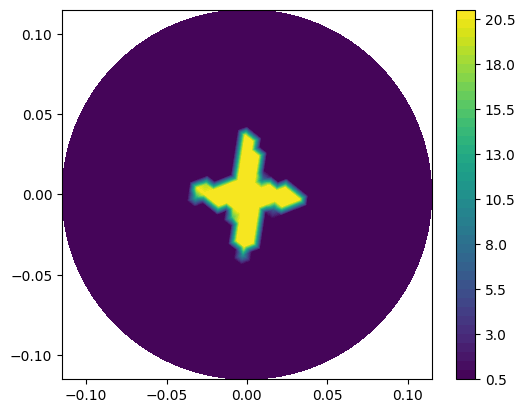

In [15]:
## Data
# Mesh used for image
Nimg = 256
himg = 0.23 / Nimg
mimg = -0.115 + himg
mesh_img = df.RectangleMesh(df.Point(mimg,mimg), df.Point(-mimg,-mimg), Nimg-1,Nimg-1)
V_img = df.FunctionSpace(mesh_img,'CG',1)
idx_img = df.dof_to_vertex_map(V_img)
idx_img2 = df.vertex_to_dof_map(V_img)

# Load data
mat_file = glob.glob(inputFolder + '/data4.mat')
mat_dict = sp.io.loadmat(mat_file[0])
Inj = mat_dict["Inj"]
Uel = mat_dict["Uel"]
Mpat = mat_dict["Mpat"]

# Load ground truth and plot
ground_truth = glob.glob(truthFolder + '/true4.mat')
truth_dict = sp.io.loadmat(ground_truth[0])

# Represent ground truth on mesh
q0_img = 20*np.flipud(truth_dict["truth"]).reshape(256**2,1)+0.8
q0 = df.Function(V_img)
q0.vector().set_local(q0_img[idx_img])
q0.set_allow_extrapolation(True)
q0 = df.interpolate(q0,V1)

# Plot
p = df.plot(q0)
plt.colorbar(p)

# Extract vector of values in the right order
q0 = q0.vector().get_local()[idx2]

# Simulate data
Uel_sim = solver.SolveForward2(q0, z)

Finite difference works as concluded from the following experiments:

In [16]:
# Starting guess
r = 0.23/4
k = np.linalg.norm(g, axis=1)
phi0 = k-r
q1 = 0.8
q2 = 20

# Initialize
phi = phi0

# MyTV object
delta = 1e-3
q = q1*(phi>0) + q2*(phi<=0)
qh = q.copy()
index = 500
h = 0.001
qh[index] += h
qfun = df.Function(V1)
qfun.vector().set_local(q[idx])

TV = MyTV(qfun,delta)

# Regularization parameter
beta = 1e-5
# Smoothness parameter
eps = 1e-3

#F = compute_functional(q,solver,Uel_sim,z,beta,idx,TV)
#Fh =  compute_functional(qh,solver,Uel_sim,z,beta,idx,TV) 
#dFdq = find_direction(q,solver,Uel_sim,z,beta,idx,TV,eps)

#print((Fh-F)/h)
#print(dFdq[index])

## Reinitialization of distance function
We need a stable way of reinitializing the level set function so that it is close to a distance function

 error : 0.117321364683311
 error : 0.07174892547372305
 error : 0.05703551868894625
 error : 0.049472147548152275
 error : 0.044648324854481655
 error : 0.04125983248826899
 error : 0.038757268172454076
 error : 0.03685445948264153
 error : 0.035382278888647
 error : 0.03423222259711413


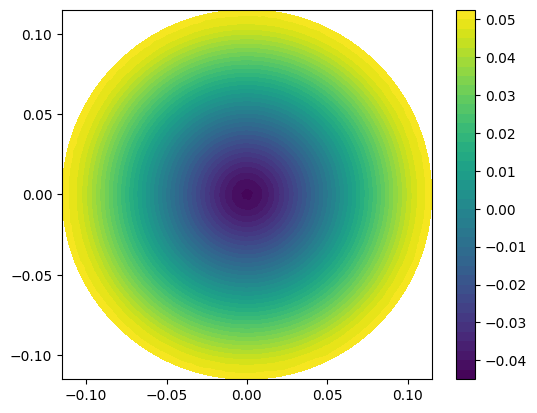

In [17]:
## Fenics based reinitialization
# This is based on backwards Euler for diffusion term and forward for the Eikonal term

def reinit(l,idx,Niter,dt,eps,alpha):
    #phifun.vector().set_local(l[idx])

    # Set the initial value
    phi = df.TrialFunction(V1); phi0 = df.Function(V1)
    w = df.TestFunction(V1)

    k = df.Constant(dt) # Time step Python
    phi0.vector().set_local(l[idx]) # Initial value

    epsdf = df.Constant(eps) # Interface thickness
    alphadf = df.Constant (alpha) # Numerical diffusion parameter

    sign_term = phi0/ df.sqrt(phi0**2 + df.inner(df.grad(phi0),df.grad(phi0))* epsdf**2)

    # FEM linearization
    a = phi*w*df.dx + k * alphadf * df.inner ( df.grad ( phi ) , df.grad (w))* df.dx  
    L = phi0*w*df.dx + k* sign_term * (1.0 - df.sqrt (df.inner( df.grad ( phi0 ) , df.grad ( phi0 ))))* w*df.dx# - k * alphadf * df.inner ( df.grad ( phi0 ) , df.grad (w))* df.dx


    #a = phi*w*df.dx -k * sign_term * (1.0 - (df.inner( df.grad ( phi ) , df.grad ( phi ))/(df.sqrt(df.inner(df.grad(phi0),df.grad(phi0))))))* w*df.dx + k * alphadf * df.inner ( df.grad ( phi ) , df.grad (w))* df.dx
    
    #a = phi*w*df.dx + k * alphadf * df.inner ( df.grad ( phi ) , df.grad (w))* df.dx  
    #L = phi0*w*df.dx 

    # Boundary condition
    bc = []
    # Flag setup
    Ei = 1e10 ; E_old = 1e10
    cont = 0; num_steps = 10

    phi = df.Function(V1)

    for i in range(Niter):
        df.solve (a == L, phi , bc)

        # Euclidean norm
        error = ((( phi - phi0 )/k )**2)* df.dx
        E = df.sqrt (abs( df.assemble ( error )))
        print(" error :", E)
        phi0.assign(phi)

        # Divergence flag
        if ( E_old < E ):
            fail = 1
            print("* Diverges at reinit *", cont)
            break
        
        cont +=1
        E_old = E
    return phi0

f = reinit(phi,idx,10,0.001,0.001,0.01)
p = df.plot(f)
plt.colorbar(p)

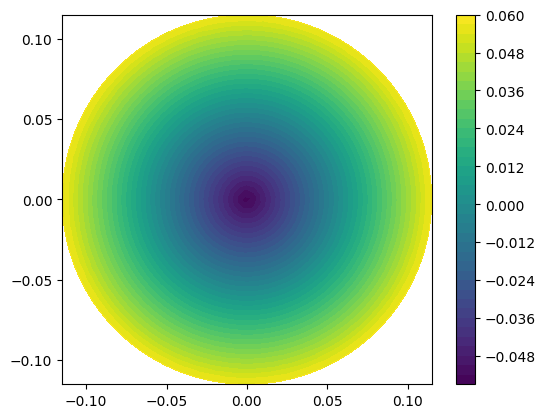

In [18]:
# Reinitialization algorithm based on Runge-Kutta4 discretization in time direction

def reinitRK(l,idx,Niter,dt,eps,alpha):
    #phifun.vector().set_local(l[idx])

    # Set the initial value
    phi = df.TrialFunction(V1)
    phi0 = df.Function(V1)
    w = df.TestFunction(V1)
    phi1 = df.Function(V1)
    phi2 = df.Function(V1)
    phi3 = df.Function(V1)
    phi4 = df.Function(V1)
    phi_new = df.Function(V1)

    k = df.Constant(dt) # Time step Python
    phi0.vector().set_local(l[idx]) # Initial value

    epsdf = df.Constant(eps) # Interface thickness
    alphadf = df.Constant (alpha) # Numerical diffusion parameter
    sixth = df.Constant(dt/6.0)

    sign_term = phi0/ df.sqrt(phi0**2 + df.inner(df.grad(phi0),df.grad(phi0))* epsdf**2)

    a = phi*w*df.dx

    # For the heat equation:
    L1heat = - alpha * df.inner(df.grad(phi0),df.grad(w)) * df.dx
    L2heat = - alpha * df.inner(df.grad(phi0 + k/2 * phi1),df.grad(w)) * df.dx
    L3heat = - alpha * df.inner(df.grad(phi0 + k/2 * phi2),df.grad(w)) * df.dx
    L4heat = - alpha * df.inner(df.grad(phi0 + k * phi3),df.grad(w)) * df.dx


    # For the Eikonal equation:
    L1eik = sign_term * (1.0 - df.sqrt (df.inner( df.grad ( phi0 ) , df.grad ( phi0 ))))* w*df.dx
    L2eik = sign_term * (1.0 - df.sqrt (df.inner( df.grad ( phi0 + k/2 * phi1 ) , df.grad ( phi0 + k/2 * phi1 ))))* w*df.dx
    L3eik = sign_term * (1.0 - df.sqrt (df.inner( df.grad ( phi0 + k/2 * phi2 ) , df.grad ( phi0 + k/2 * phi2 ))))* w*df.dx
    L4eik = sign_term * (1.0 - df.sqrt (df.inner( df.grad ( phi0 + k * phi3 ) , df.grad ( phi0 + k * phi3 ))))* w*df.dx


    L1 = L1heat + L1eik
    L2 = L2heat + L2eik
    L3 = L3heat + L3eik
    L4 = L4heat + L4eik
    #a = phi*w*df.dx -k * sign_term * (1.0 - (df.inner( df.grad ( phi ) , df.grad ( phi ))/(df.sqrt(df.inner(df.grad(phi0),df.grad(phi0))))))* w*df.dx + k * alphadf * df.inner ( df.grad ( phi ) , df.grad (w))* df.dx
    
    #a = phi*w*df.dx + k * alphadf * df.inner ( df.grad ( phi ) , df.grad (w))* df.dx  
    #L = phi0*w*df.dx 

    # Boundary condition
    bc = []
    # Flag setup
    Ei = 1e10 ; E_old = 1e10
    cont = 0; num_steps = 10



    for i in range(Niter):
        
        df.solve (a == L1, phi1, bc)
        #phi1.assign(phi11)

        df.solve (a == L2, phi2, bc)
        #phi2.assign(phi21)

        df.solve (a == L3, phi3, bc)
        #phi3.assign(phi31)

        df.solve (a == L4, phi4, bc)
        #phi4.assign(phi41)


        phi_new = phi0 + sixth * (phi1 + 2*phi2 + 2*phi3 + phi4)


        # Euclidean norm
        error = ((( phi_new - phi0 )/k )**2)* df.dx
        E = df.sqrt (abs( df.assemble ( error )))
        #print(" error :", E)

        

        # Divergence flag
        if ( E_old < E ):
            fail = 1
            print("* Diverges at reinit *", cont)
            break
        
        cont +=1
        E_old = E

        phi0.assign(phi_new)

    return phi0

phi2 = np.ones(phi.shape)
f = reinitRK(phi,idx,20,0.0005,0.001,0.0005)
p = df.plot(f)
plt.colorbar(p)

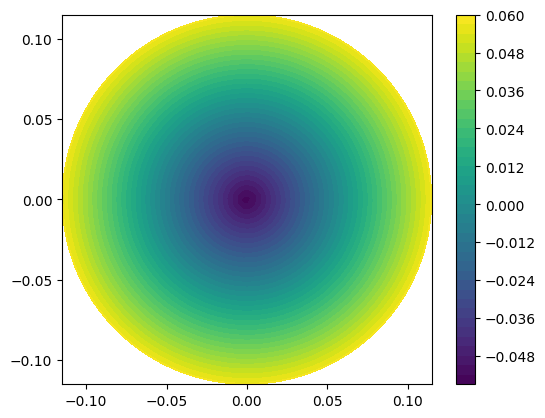

In [19]:
f.vector().set_local(phi[idx]) # Initial value
p = df.plot(f)
plt.colorbar(p)

## Time for the algorithm

1. Computes direction from negative gradient
2. Picks step size from backtracking line search
3. Reinitializes level set function when it has changed 15% or 7 iterations has passed. This step also smoothenes the level set 

In [20]:


# Reinitialization parameters
alpha_dif = 7.0*1e-4 # diffusion parameter
dt = 2.0*1e-4
Ninit = 50

# Regularization parameter
beta = 1e-9
# Smoothness parameter
eps = 1e-3
# Step size
alpha0 = 0.01
# Number of iterations
Miter = 400

# Backtracking line search
tau = 0.5
c = 0.005

# Starting guess
r = 0.23/4
k = np.linalg.norm(g, axis=1)
phi0 = k-r
q1 = 0.8
q2 = 20

# Initialize level set function
phik = phi0
phi = phik
phik_new = phi

q = q1*(phik>0) + q2*(phik<=0)
# Consider an L1 function
qfun = df.Function(V1)
qfun.vector().set_local(q[idx])

# Initialize Total variation object
delta = 1e-3 # TV smoothness parameter
TV = MyTV(qfun,delta)

# Initial functional value
F0 = compute_functional(q,solver,Uel_sim,z,beta,idx,TV)

for i in range(Miter):
    # Reinitialize step size
    alpha = alpha0

    dF = find_direction(phik,q,solver,Uel_sim,z,beta,idx,TV,eps)

    # Try a step in that direction
    phik_new = phik_new + alpha * dF
    q = q1*(phik_new>0) + q2*(phik_new<=0) 
    qfun.vector().set_local(q[idx])
    F = compute_functional(q,solver,Uel_sim,z,beta,idx,TV)
    
    # Backtracking line search 
    tt = c * np.linalg.norm(dF)**2
    j = 0
    while(F0-F < alpha*tt and F0-F > 1e-5):
        j = j+1
        alpha = tau*alpha
        phik_new = phik_new + alpha * dF
        q = q1*(phik_new>0) + q2*(phik_new<=0)  
        qfun.vector().set_local(q[idx])
        F = compute_functional(q,solver,Uel_sim,z,beta,idx,TV)

    # Take a step of length alpha in that direction
    print("Stepsize =", alpha)
    print("Loss =", F)
    phik = phik + alpha * dF
    q = q1*(phik>0) + q2*(phik<=0)  
    F0 = F
    
    print("Iteration", i)


    # if solution is changed more than 10% we reinitialize and recompute TV object
    if np.linalg.norm(phik-phi)/np.linalg.norm(phi) > 0.15 or time_since_last >= 7:
        print("Reinitializing")
        phik = reinitRK(phik,idx,Ninit,dt,eps,alpha_dif).vector().get_local()[idx2]
        phi = phik.copy()
        q = q1*(phi>0) + q2*(phi<=0) 
        qfun.vector().set_local(q[idx])
        TV.update_op(qfun)
        F = compute_functional(q,solver,Uel_sim,z,beta,idx,TV)
        time_since_last = 0
        #print("Loss =", F)
    
    time_since_last += 1





Stepsize = 0.02
Loss = 0.9165361828233707
Iteration 0
Reinitializing
Stepsize = 0.02
Loss = 0.6692017358722705
Iteration 1
Reinitializing
Stepsize = 0.02
Loss = 0.5155752431996413
Iteration 2
Reinitializing
Stepsize = 0.02
Loss = 0.34929359184388986
Iteration 3
Reinitializing
Stepsize = 0.02
Loss = 0.23525818801749845
Iteration 4
Reinitializing
Stepsize = 0.02
Loss = 0.13545397279642898
Iteration 5
Reinitializing
Stepsize = 0.02
Loss = 0.07110060419091727
Iteration 6
Stepsize = 0.02
Loss = 0.05861260660288281
Iteration 7
Reinitializing
Stepsize = 0.02
Loss = 0.035147293720962196
Iteration 8


KeyboardInterrupt: 

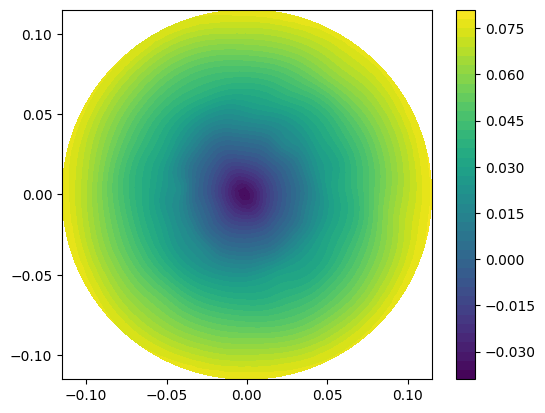

In [22]:
phik2 = reinitRK(phik,idx,Ninit,2.0*1e-4,eps,8.0*1e-4).vector().get_local()[idx2]
#phi = phik2
q = q1*(phik2>0) + q2*(phik2<=0) 
qfun.vector().set_local(phik2[idx])

p = df.plot(qfun)
plt.colorbar(p)

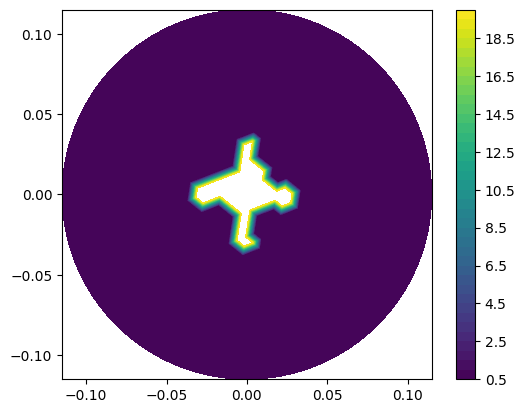

In [90]:
qfun.vector().set_local(q[idx])
p = df.plot(qfun)
plt.colorbar(p)

## Code output vs ground truth for noiseless perfect data

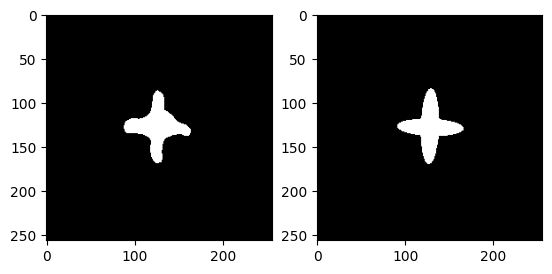

In [122]:
phi_grid = KTCAux.interpolateRecoToPixGrid(phik, Mesh)
q = 0*(phi_grid>0) + 2*(phi_grid<0)
#q[q==0.] = 0
#q[q<=q1] = 0

#mesh_img.coordinates()
#q[q<q1] = 0
fig, ax = plt.subplots(1,2)
ax[0].imshow(q, cmap="gray")
ax[1].imshow(truth_dict["truth"], cmap="gray")